In [49]:
import json
from pprint import pprint
import os

feature_vector_file_name = "_d_cnt_log_move_flip_fv.json"
file_path = f"{os.getcwd()}/data/{feature_vector_file_name}"

with open(file_path) as f:
  data = json.load(f)

pprint(data[:5])

[[9, 1.792, 0],
 [256, 3.638, 3],
 [49, 3.045, 0],
 [121, 3.584, 4],
 [36, 2.833, 1]]


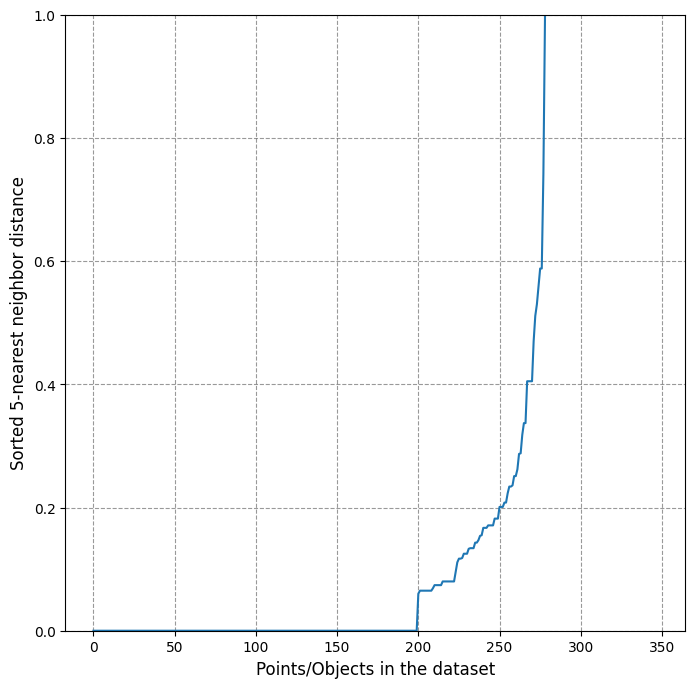

dat shape; col: 348  row: 3
348
[ 0  0  0  0  1  2  3  4  5  6  3  2  5  2  3  0  0  2  2  0  2  2  2  2
  2  2  2  2  2  4  4  0  7  4  0  2  4  2  4  8  2  4  8  2  4  8  2  4
  0  4  2  4  2  8  4  2  8  4  2  8  4  2  0  0  2  9  0  0  2  9  0  8
  2  2  2  2  2  4  2  2  2  2  2  2  0  2  4  4  4  2  4  4  4  5  5  5
  8  7  7  0  2  2  2  2  2  8 10  5 10  5 10  5  4  2 11  2  2  4  0  0
  4  9  2  2  2  2  2  2  2  2  0  4 12  2 12  8  2 13 11 11  3  2  2  2
  2  2  2  2  2  0  2 12  2 12 11  4  1 11 11  5  0  0  0  9  1  0 11  3
  5  3  0  2  2  2  8  0  0  0  2  4  2  2  2  3  2  1  4  2  4  8  2  0
  2  0  0  5  4  0 13 13 13 13 13  0  4  2  4  0  2  2  2  2  4  2  2  0
  2  1 11 11  4  1 11 11  3  0  5 11 11  2  1 11 11  5  6  6  0  0  3  8
  3  8  1  8  3  8  2  8  8  2  8  8  2  1  1  1  2  0  2  4  4  2 13 13
  1  8  2  2  0  0  0  0  0  2  0  9  8  9  8  9  8  9  8  0  1  1  2  0
  0  0  5  2  4  4  4  2  4  4  4  8  8  2  2  1  1  8  3  8  1  8  3  8
  2  0  2  9  4  0 

In [50]:
from sklearn.cluster import AffinityPropagation,MeanShift,DBSCAN,OPTICS,estimate_bandwidth
import numpy as np

data = np.array(data)

method = "AffinityPropagation"
method = "MeanShift"
method = "DBSCAN"
# method = "OPTICS"

if method == "AffinityPropagation":
  # TODO: シルエットスコアで調節した結果を評価するといいらしいとChatGPTが言ってた
  # preference
  # -200は細かいかなって感じ
  # -400がまあって感じ
  # -800はやりすぎかなって感じ
  # damping
  clustering_result = AffinityPropagation(
      random_state=5,
      preference=-1,
      damping=0.9
    ).fit_predict(data)
elif method == "MeanShift":
  bw = estimate_bandwidth(data, quantile=0.05, n_samples=500)
  print("bw",bw)
  clustering_result = MeanShift(
      bandwidth=bw
    ).fit_predict(data)
elif method == "DBSCAN":
  # init eps = 0.5, min samples=5
  import numpy as np
  from sklearn.neighbors import NearestNeighbors
  import matplotlib.pyplot as plt

  def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):
      nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

      # For each point, compute distances to its k-nearest neighbors
      distances, indices = nbrs.kneighbors(X) 

      distances = np.sort(distances, axis=0)
      distances = distances[:, k-1]

      # Plot the sorted K-nearest neighbor distance for each point in the dataset
      plt.figure(figsize=(8,8))
      plt.plot(distances)
      plt.xlabel('Points/Objects in the dataset', fontsize=12)
      plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
      plt.grid(True, linestyle="--", color='black', alpha=0.4)
      plt.ylim((0,1))
      plt.show()
      plt.close()

  k = 2 * len(data[0]) - 1 # k=2*{dim(dataset)} - 1
  get_kdist_plot(X=data, k=k)
  clustering_result = DBSCAN(eps=0.5, min_samples=3).fit_predict(data)
elif method == "OPTICS":
  clustering_result = OPTICS(
      min_samples=5,
      max_eps=np.inf,
      cluster_method="xi",
      xi=0.5,
    ).fit_predict(data)

clustering_result += 1

print("dat shape; col:", len(data)," row:", len(data[0]))
print(len(clustering_result))
print(clustering_result)
clustering_labels = set(clustering_result)
print(len(clustering_labels),clustering_labels)

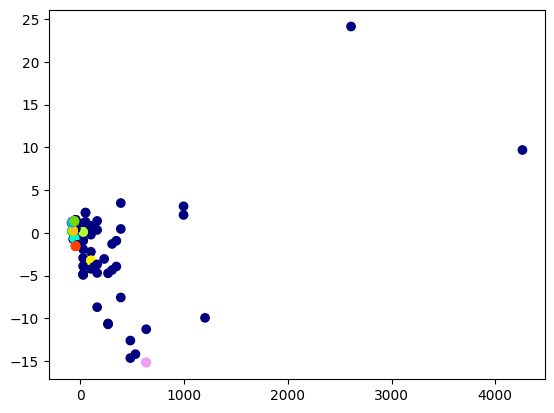

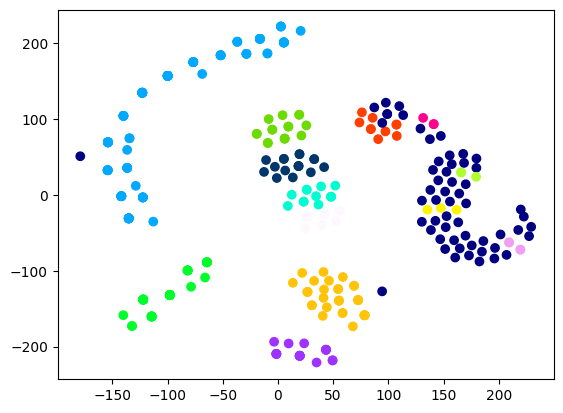

/home/iharuki/zemi/team/2023/watahal_proseka-score/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


array([[-8.52469826e+00,  1.41088638e+01],
       [ 1.40182579e+00,  5.92996931e+00],
       [ 1.61480179e+01,  8.09957600e+00],
       [ 4.49105453e+00,  6.15452719e+00],
       [ 1.16566410e+01,  2.50796890e+00],
       [ 7.05603743e+00,  1.87650337e+01],
       [-7.93358278e+00, -7.97680855e-01],
       [-1.95417747e+01,  9.51097250e-01],
       [ 5.11395097e-01, -5.12659502e+00],
       [ 4.45931292e+00,  6.30829430e+00],
       [-7.94875431e+00, -8.40578079e-01],
       [-9.34910583e+00,  1.38124781e+01],
       [ 4.56821918e-01, -5.18114853e+00],
       [ 7.09517527e+00,  1.86945248e+01],
       [-7.95970774e+00, -8.34187865e-01],
       [ 4.46890259e+00,  6.21763468e+00],
       [ 2.76307940e+00,  5.73068714e+00],
       [ 7.08295631e+00,  2.02266941e+01],
       [ 7.17684126e+00,  2.03311310e+01],
       [ 2.83943462e+00,  5.75250673e+00],
       [-9.92313099e+00,  1.38830709e+01],
       [ 6.99018526e+00,  2.01931648e+01],
       [-9.60895443e+00,  1.39907942e+01],
       [-8.

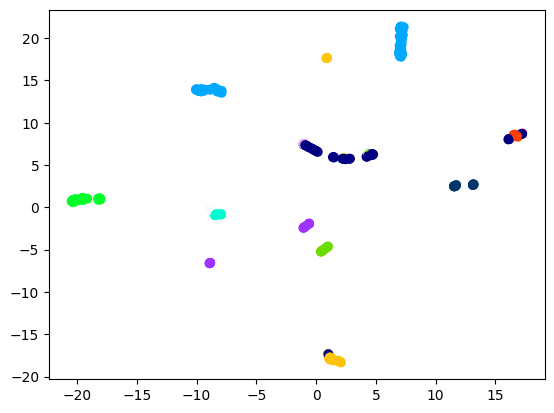

In [51]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import datetime

save_dir_name = "_vis-result"
dir_path = f"./data/{save_dir_name}/"
time_dir_path = dir_path + f"{str(datetime.date.today())}/"
try:
    os.mkdir(dir_path)
except FileExistsError:
    pass
try:
    os.mkdir(time_dir_path)
except FileExistsError:
    pass

data = np.array(data)
file_explain = f"{datetime.datetime.now().time()}_clustering_{method}"

from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)
data_pca = pca.fit_transform(data)

plt.scatter(data_pca[:,0],data_pca[:,1], c=clustering_result, cmap="gist_ncar")
plt.savefig(time_dir_path + f"{file_explain}_plot-pca.png")
plt.show()

tsne = TSNE(n_components=2, random_state=0)
data_tsne = tsne.fit_transform(data)

plt.scatter(data_tsne[:,0],data_tsne[:,1], c=clustering_result, cmap="gist_ncar")
plt.savefig(time_dir_path + f"{file_explain}_plot-tsne.png")
plt.show()

from umap import UMAP

umap = UMAP(n_components=2, random_state=0)
data_umap = umap.fit_transform(data)
pprint(data_umap)

plt.scatter(data_umap[:,0],data_umap[:,1], c=clustering_result, cmap="gist_ncar")
plt.savefig(time_dir_path + f"{file_explain}_plot-umap.png")
plt.show()

In [12]:
import os
import datetime
from section_divide import get_section


notes_file_path = "./data/m155_notes-test.json"
sections = get_section(notes_file_path)

clustering_labels = set(clustering_result)

for label in clustering_labels:
    # ラベルが一致するデータのみをフィルタリング
    # plt.scatter(data_subset[:, 0], data_subset[:, 1], label=str(label))    

    data_range = clustering_result == label
    data_subset = data[data_range]
    section_subset = [s for s,d in zip(sections,data_range) if d]
    
    for i,section in enumerate(section_subset):
        xs = [item["x"] for item in section]
        ys = [item["y"] for item in section]

In [52]:
import json
from pprint import pprint
from section_divide import get_section

file_path = "./data/_feature_vector.json"


with open(file_path) as f:
  data = json.load(f)
data = np.array(data)
# cluster_labels = set(clustering_result)


# pprint(sections[1])
print(len(sections), len(clustering_result))
label_by_note_count:dict[int,set] = dict()
cnt_by_note_count:dict[int,int] = dict()

note_count_by_label:dict[int,set] = dict()

note4_sections =  list()
note4_sections_idx =  list()

for i,section in enumerate(sections):
  
  if label_by_note_count.get(len(section)) is not None:
    label_by_note_count[len(section)].add(clustering_result[i])
    cnt_by_note_count[len(section)] += 1
  else:
    label_by_note_count[len(section)] = set()
    cnt_by_note_count[len(section)] = 0
  
  if note_count_by_label.get(clustering_result[i]) is not None:
    note_count_by_label[clustering_result[i]].add(len(section))
  else:
    note_count_by_label[clustering_result[i]] = set()
    
  if len(section) == 4:
    note4_sections.append(section)
    note4_sections_idx.append(i)

print("=== ノーツ数が4である区間の数，ノーツ数が4である区間のラベルの数，そのラベル")
print(cnt_by_note_count[4], len(label_by_note_count[4]), label_by_note_count[4])
print("=====")

# print("=== 「ノーツ数が4であるラベル」に属する区間が持つノーツ数")
# for label in label_by_note_count[4]:
#   print(label,note_count_by_label[label])
# print("=====")

clustering_labels = set(clustering_result)
from collections import defaultdict
data_by_label = defaultdict(set)
for i in range(len(data)):
  data_by_label[clustering_result[i]].add(i)


notes_file_path = "./data/m155_notes-test.json"
sections = get_section(notes_file_path)

ns = defaultdict(list)
for l in label_by_note_count[4]:
  ids = data_by_label[l]
  for i in ids:
    ns[len(sections[i])].append(i)
    # if len(sections[i]) == 4:
    #   n4.append(i)

for k,v in ns.items():
  print(f"note count = {k}\tlength = {len(v)}")

# import matplotlib.pyplot as plt

# # print("===")
# for i,idx in enumerate(note4_sections_idx):
#   find = False
#   for j,jdx in enumerate(note4_sections_idx):
#     if clustering_result[idx] == clustering_result[jdx]:
#       continue
    
#     print(clustering_result[idx], clustering_result[jdx])
    
#     fig = plt.figure(figsize = (10,4), facecolor='lightblue')
#     ax1 = fig.add_subplot(1, 2, 1)
#     ax2 = fig.add_subplot(1, 2, 2)

    
#     xs = [item["x"] for item in note4_sections[i]]
#     ys = [item["y"] for item in note4_sections[i]]
#     miny = min(ys)
#     ys = [y-miny for y in ys]
#     ax1.scatter(xs,ys, color="b", label=clustering_result[note4_sections_idx[idx]])
#     ax1.set_xlim([-0.3,12.3])
#     # ax1.set_ylim(bottom=0)
    
#     xs = [item["x"] for item in note4_sections[j]]
#     ys = [item["y"] for item in note4_sections[j]]
#     miny = min(ys)
#     ys = [y-miny for y in ys]
#     ax2.scatter(xs,ys,color="r", label=clustering_result[note4_sections_idx[jdx]])
#     ax2.set_xlim([-0.3,12.3])

#     plt.show()
    
#     break
#   else:
#     continue
  
#   break


# pprint(note4_sections[0])
# print("&")
# pprint(note4_sections[1])
# print("=====")


348 348
=== ノーツ数が4である区間の数，ノーツ数が4である区間のラベルの数，そのラベル
158 2 {2, 4}
=====
note count = 4	length = 159


In [53]:
clustering_labels = set(clustering_result)
# print(len(clustering_labels),clustering_labels)


import os
import datetime

from section_divide import get_section


notes_file_path = "./data/m155_notes-test.json"
sections = get_section(notes_file_path)


base_dir = "./data/_vis-result"
time_dir_path = f"{base_dir}/{str(datetime.date.today())}"
cluster_labels_dir = f"{time_dir_path}/{str(datetime.datetime.now().time())}-cluster-labels"

try:
    os.mkdir(base_dir)
except FileExistsError:
    pass
try:
    os.mkdir(time_dir_path)
except FileExistsError:
    pass
try:
    os.mkdir(cluster_labels_dir)
except FileExistsError:
    pass

for label in clustering_labels:
    # ラベルが一致するデータのみをフィルタリング
    # plt.scatter(data_subset[:, 0], data_subset[:, 1], label=str(label))
    
    dir_path = f"{cluster_labels_dir}/label-{label}/"
    try:
        os.mkdir(dir_path)
    except FileExistsError:
        pass
    
    
    file_name = f"{str(datetime.datetime.now().time())}"
    print(file_name)
    
    data_range = clustering_result == label
    # print(data_range)
    data_subset = data[data_range]
    section_subset = [s for s,d in zip(sections,data_range) if d]
    
    for i,section in enumerate(section_subset):
        xs = [item["x"] for item in section]
        ys = [item["y"] for item in section]
        plt.scatter(xs,ys, color="b", label=label)
        plt.xlim([-0.3,12.3])
        plt.savefig(f"{dir_path}{i}_{file_name}.png")
        plt.close()

# plt.legend()
# plt.xlim(left=-5)
# plt.show()

23:12:08.420213
23:12:16.119902
23:12:19.315990
23:12:38.151849
23:12:40.089203
23:12:46.604300
23:12:49.026191
23:12:49.472570
23:12:49.953458
23:12:54.867513
23:12:56.283038
23:12:57.224235
23:13:00.382513
23:13:01.059451
